## Installs

In [ ]:
! pip install h5py --quiet

## Connect to drive

In [ ]:
from google.colab import drive
drive.mount("/content/gDrive")

Mounted at /content/gDrive


## Using GPU

In [ ]:
import torch
def get_default_device():
  if torch.cuda.is_available(): return torch.device("cuda")
  else: return torch.device("cpu")

def to_device(data, device):
  if isinstance(data, (list, tuple)): return [to_device(x, device) for x in data]
  return data.to(device, non_blocking = True)

class DeviceDataLoader():
  def __init__(self, dataloader, device):
    self.dataloader, self.device = dataloader, device
  def __iter__(self):
    for batch in self.dataloader: yield to_device(batch, self.device)
  def __len__(self):
    return len(self.dataloader)

In [ ]:
device = get_default_device()
print(f"default device on this system is {device} !!!")

default device on this system is cuda !!!


## Utils

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def show_result(losses_list,losses_val, epoch_num):
  sns.set_style("darkgrid")
  fig, axes = plt.subplots(1, figsize=(6,6))
  axes.scatter(np.arange(start=1, stop=epoch_num+1), np.array(losses_list))
  axes.plot(np.arange(start=1, stop=epoch_num+1), np.array(losses_val))

## Loading Data

In [ ]:
import os
from sklearn.model_selection import train_test_split
dataPath = "/content/gDrive/MyDrive/Elastography/PicmusData"

inputTypeList, targetList = os.listdir(dataPath + "/Input"), os.listdir(dataPath + "/Output")
inputDict = {name:os.listdir(dataPath+"/Input/"+name) for name in inputTypeList}

inputList = []
for key in inputDict:
  for item in inputDict[key]:
    inputList.append(key + "/" + item)
    inputList.append(key + "/" + item)

input_train_list, input_test_list = train_test_split(inputList, test_size=0.305, random_state=101)
input_test_list, input_val_list = train_test_split(input_test_list, test_size=0.33, random_state=101)
# tune the test sizes. the number of each list should be even.
print(len(input_train_list))
print(len(input_test_list))
print(len(input_val_list))

422
124
62


In [ ]:
import torch
import h5py
import cv2 as cv
import numpy as np
from torchvision.transforms import transforms as T
from torch.utils.data import Dataset

class PicmusDatasetCreator(Dataset):
  def __init__(self, inputPath, targetPath, inputList, in_shape, out_shape
                                                         , in_type="amp"
                                                         , out_type = "amp"):
    super(PicmusDatasetCreator, self).__init__()
    self.input_list = inputList
    self.in_type, self.out_type = in_type, out_type
    self.input_path, self.target_path = inputPath, targetPath
    self.in_shape, self.out_shape = in_shape, out_shape

  def get_input_data(self, fFile, idx):
    real = np.array(list(fFile["US"]["US_DATASET0000"]["data"]["real"])[:])
    imag = np.array(list(fFile["US"]["US_DATASET0000"]["data"]["imag"])[:])
    amp = (np.array(real)[:]**2+np.array(imag)[:]**2)**0.5
    phase =  np.arctan(np.array(imag)[:])/(np.array(real)[:])

    if len(real.shape) == 2:
      real, imag = cv.resize(real, self.in_shape), cv.resize(imag, self.in_shape)
      amp, phase = cv.resize(amp, self.in_shape), cv.resize(phase, self.in_shape)
    else:
      real, imag = cv.resize(real[idx,:,:], self.in_shape), cv.resize(imag[idx,:,:], self.in_shape)
      amp, phase = cv.resize(amp[idx,:,:], self.in_shape), cv.resize(phase[idx,:,:], self.in_shape)

    real, imag = np.expand_dims(real, axis=0), np.expand_dims(imag, axis=0)
    amp, phase = np.expand_dims(amp, axis=0), np.expand_dims(phase, axis=0)

    if self.in_type == "amp":  data = amp
    elif self.in_type == "real":  data = real
    elif self.in_type == "channel": data = np.concatenate((real, imag), axis=0)

    mean, std = torch.mean(torch.tensor(data), [1,2]), torch.std(torch.tensor(data), [1,2])
    transform = T.Compose([T.Normalize((0.5), (0.5))])
    return data/torch.max(torch.tensor(data)).numpy()

  def get_output_data(self, fFile):
    real = np.array(list(fFile["US"]["US_DATASET0000"]["data"]["real"])[:])
    imag = np.array(list(fFile["US"]["US_DATASET0000"]["data"]["imag"])[:])
    amp = (np.array(real)[:]**2+np.array(imag)[:]**2)**0.5
    phase =  np.arctan(np.array(imag)[:])/(np.array(real)[:])

    real, imag = cv.resize(real, self.out_shape), cv.resize(imag, self.out_shape)
    amp, phase = cv.resize(amp, self.out_shape), cv.resize(phase, self.out_shape)

    real, imag = np.expand_dims(real, axis=0), np.expand_dims(imag, axis=0)
    amp, phase = np.expand_dims(amp, axis=0), np.expand_dims(phase, axis=0)

    if self.out_type == "amp": data = amp
    elif self.out_type == "real": data = real
    elif self.out_type == "channel": data = np.concatenate((real, imag), axis=0)

    mean, std = torch.mean(torch.tensor(data), [1,2]), torch.std(torch.tensor(data), [1,2])
    transform = T.Compose([T.Normalize((0.5), (0.5))])
    return data/torch.max(torch.tensor(data)).numpy()

  def __getitem__(self, index):
    xFile = h5py.File(self.input_path + self.input_list[index], "r")
    if index % 2 == 0:  x = self.get_input_data(xFile, 0)
    else:  x = self.get_input_data(xFile, -1)

    targetFile = self.input_list[index].split("/")[1].replace("dataset", "image").split("_")
    targetFile[-1] = "75.hdf5"
    targetFile = '_'.join(targetFile)
    yFile = h5py.File(self.target_path + targetFile, "r")
    y = self.get_output_data(yFile)

    return x, y

  def __len__(self):
    return len(self.input_list)

In [ ]:
input_path = "/content/gDrive/MyDrive/Elastography/PicmusData/Input/"
target_path = "/content/gDrive/MyDrive/Elastography/PicmusData/Output/"
train_ds = PicmusDatasetCreator(input_path, target_path, input_train_list, (384,128), (768, 383), "channel", "real")
train_ds = PicmusDatasetCreator(input_path, target_path, input_test_list, (384,128), (768, 383), "channel", "real")
train_ds = PicmusDatasetCreator(input_path, target_path, input_val_list, (384,128), (768, 383), "channel", "real")

In [ ]:
from torch.utils.data import DataLoader
class LoadData:
  def __init__(self, inputPath, targetPath, inputList, batchSize=32, in_type="amp"
                                                                    ,out_type = "amp"):
    self.input_path, self.target_path = inputPath, targetPath
    self.in_type, self.out_type = in_type, out_type
    self.input_list, self.batch = inputList, batchSize

  def create_dataset(self):
    dataset = PicmusDatasetCreator(self.input_path, self.target_path, self.input_list
                                                               ,(384,128), (384,128)
                                                        , self.in_type,self.out_type)
    return dataset

  def create_dataLoader(self):
    dataset = self.create_dataset()
    dataLoader = DataLoader(dataset, batch_size=self.batch, shuffle=True)
    return dataLoader

In [ ]:
input_path = "/content/gDrive/MyDrive/Elastography/PicmusData/Input/"
target_path = "/content/gDrive/MyDrive/Elastography/PicmusData/Output/"
train_data_loader = LoadData(input_path, target_path, input_train_list, batchSize=1, in_type="real", out_type="real")
train_dl = train_data_loader.create_dataLoader()
train_dl = DeviceDataLoader(train_dl, device)

test_data_loader = LoadData(input_path, target_path, input_test_list, batchSize=1, in_type="real", out_type="real")
test_dl = test_data_loader.create_dataLoader()
test_dl = DeviceDataLoader(test_dl, device)

val_data_loader = LoadData(input_path, target_path, input_val_list, batchSize=4, in_type="real", out_type="real")
val_dl = val_data_loader.create_dataLoader()
val_dl = DeviceDataLoader(val_dl, device)

#Network2

In [ ]:
import torch
import torch.nn.functional as F
from torch import nn


def _squash(input_tensor, dim=2):
    """
    Applies norm nonlinearity (squash) to a capsule layer.
    Args:
    input_tensor: Input tensor. Shape is [batch, num_channels, num_atoms] for a
        fully connected capsule layer or
        [batch, num_channels, num_atoms, height, width] or
        [batch, num_channels, num_atoms, height, width, depth] for a convolutional
        capsule layer.
    Returns:
    A tensor with same shape as input for output of this layer.
    """
    epsilon = 1e-12
    norm = torch.linalg.norm(input_tensor, dim=dim, keepdim=True)
    norm_squared = norm * norm
    return (input_tensor / (norm + epsilon)) * (norm_squared / (1 + norm_squared))


def _update_routing(votes, biases, num_routing):
    """
    Sums over scaled votes and applies squash to compute the activations.
    Iteratively updates routing logits (scales) based on the similarity between
    the activation of this layer and the votes of the layer below.
    Args:
        votes: tensor, The transformed outputs of the layer below.
        biases: tensor, Bias variable.
        num_dims: scalar, number of dimmensions in votes. For fully connected
        capsule it is 4, for convolutional 2D it is 6, for convolutional 3D it is 7.
        num_routing: scalar, Number of routing iterations.
    Returns:
        The activation tensor of the output layer after num_routing iterations.
    """
    votes_shape = votes.size()

    logits_shape = list(votes_shape)
    logits_shape[3] = 1
    logits = torch.zeros(logits_shape, requires_grad=False, device=votes.device)

    for i in range(num_routing):
        route = F.softmax(logits, dim=2)
        preactivate = torch.sum(votes * route, dim=1) + biases[None, ...]

        if i + 1 < num_routing:
            distances = F.cosine_similarity(preactivate[:, None, ...], votes, dim=3)
            logits = logits + distances[:, :, :, None, ...]
        else:
            activation = _squash(preactivate)
    return activation

In [ ]:
class DepthwiseConv3d(nn.Module):
    """
    Performs 2D convolution given a 5D input tensor.
    This layer given an input tensor of shape
    `[batch, input_dim, input_atoms, input_height, input_width]` squeezes the
    first two dimmensions to get a 4D tensor as the input of torch.nn.Conv2d. Then
    splits the first dimmension and the second dimmension and returns the 6D
    convolution output.
    Args:
        kernel_size: scalar or tuple, convolutional kernels are [kernel_size, kernel_size].
        input_dim: scalar, number of capsules in the layer below.
        output_dim: scalar, number of capsules in this layer.
        input_atoms: scalar, number of units in each capsule of input layer.
        output_atoms: scalar, number of units in each capsule of output layer.
        stride: scalar or tuple, stride of the convolutional kernel.
        padding: scalar or tuple, zero-padding added to both sides of the input
        dilation: scalar or tuple, spacing between kernel elements
        share_weight: share transformation weight matrices between capsules in lower layer or not
    Returns:
        6D Tensor output of a 2D convolution with shape
        `[batch, input_dim, output_dim, output_atoms, out_height, out_width]`.
    """

    def __init__(
        self,
        kernel_size,
        input_dim,
        output_dim,
        input_atoms=8,
        output_atoms=8,
        stride=2,
        dilation=1,
        padding=0,
        share_weight=True,
    ):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_atoms = input_atoms
        self.output_atoms = output_atoms
        self.share_weight = share_weight

        if self.share_weight:
            self.conv2d = nn.Conv2d(
                input_atoms, output_dim * output_atoms, kernel_size, stride=stride, dilation=dilation, padding=padding
            )
        else:
            self.conv2d = nn.Conv2d(
                input_dim * input_atoms,
                input_dim * output_dim * output_atoms,
                kernel_size=kernel_size,
                stride=stride,
                dilation=dilation,
                padding=padding,
                groups=input_dim,
            )
        torch.nn.init.normal_(self.conv2d.weight, std=0.1)

    def forward(self, input_tensor):
        input_shape = input_tensor.size()

        if self.share_weight:
            input_tensor_reshaped = input_tensor.view(
                input_shape[0] * self.input_dim, self.input_atoms, input_shape[-2], input_shape[-1]
            )
        else:
            input_tensor_reshaped = input_tensor.view(
                input_shape[0], self.input_dim * self.input_atoms, input_shape[-2], input_shape[-1]
            )

        conv = self.conv2d(input_tensor_reshaped)
        conv_shape = conv.size()

        conv_reshaped = conv.view(
            input_shape[0], self.input_dim, self.output_dim, self.output_atoms, conv_shape[-2], conv_shape[-1]
        )
        return conv_reshaped


class ConvSlimCapsule2D(nn.Module):
    """
    Builds a slim convolutional capsule layer.
    This layer performs 2D convolution given 5D input tensor of shape
    `[batch, input_dim, input_atoms, input_height, input_width]`. Then refines
    the votes with routing and applies Squash non linearity for each capsule.
    Each capsule in this layer is a convolutional unit and shares its kernel over
    the position grid and different capsules of layer below. Therefore, number
    of trainable variables in this layer is:
        kernel: [kernel_size, kernel_size, input_atoms, output_dim * output_atoms]
        bias: [output_dim, output_atoms]
    Output of a conv2d layer is a single capsule with channel number of atoms.
    Therefore conv_slim_capsule is suitable to be added on top of a conv2d layer
    with num_routing=1, input_dim=1 and input_atoms=conv_channels.
    Args:
        kernel_size: scalar or tuple, convolutional kernels are [kernel_size, kernel_size].
        input_dim: scalar, number of capsules in the layer below.
        output_dim: scalar, number of capsules in this layer.
        input_atoms: scalar, number of units in each capsule of input layer.
        output_atoms: scalar, number of units in each capsule of output layer.
        stride: scalar or tuple, stride of the convolutional kernel.
        padding: scalar or tuple, zero-padding added to both sides of the input
        dilation: scalar or tuple, spacing between kernel elements
        num_routing: scalar, number of routing iterations.
        share_weight: share transformation weight matrices between capsules in lower layer or not
    Returns:
        Tensor of activations for this layer of shape
        `[batch, output_dim, output_atoms, out_height, out_width]`
    """

    def __init__(
        self,
        kernel_size,
        input_dim,
        output_dim,
        input_atoms=8,
        output_atoms=8,
        stride=2,
        dilation=1,
        padding=0,
        num_routing=3,
        share_weight=True,
    ):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.output_atoms = output_atoms
        self.num_routing = num_routing
        self.biases = nn.Parameter(torch.nn.init.constant_(torch.empty(output_dim, output_atoms, 1, 1), 0.1))
        self.depthwise_conv3d = DepthwiseConv3d(
            kernel_size=kernel_size,
            input_dim=input_dim,
            output_dim=output_dim,
            input_atoms=input_atoms,
            output_atoms=output_atoms,
            stride=stride,
            dilation=dilation,
            padding=padding,
            share_weight=share_weight,
        )

    def forward(self, input_tensor):
        votes = self.depthwise_conv3d(input_tensor)
        return _update_routing(votes, self.biases, self.num_routing)


In [ ]:
import time
class UCaps(nn.Module):

  def feature_extractor(self, in_channel, out_channel=64):
    channels_list = [in_channel,16,32,out_channel]
    block = nn.Sequential(
        nn.Conv2d(channels_list[0], channels_list[1], kernel_size=3, padding=1,stride=1),
        nn.BatchNorm2d(num_features=channels_list[1]),
        nn.LeakyReLU(negative_slope=0.2),

        nn.Conv2d(channels_list[1], channels_list[2], kernel_size=3, padding=1,stride=1),
        nn.BatchNorm2d(num_features=channels_list[2]),
        nn.LeakyReLU(negative_slope=0.2),

        nn.Conv2d(channels_list[2], channels_list[3], kernel_size=3, padding=1,stride=1),
        nn.BatchNorm2d(num_features=channels_list[3]),
        nn.LeakyReLU(negative_slope=0.2),
    )
    return block

  def ucaps_encode_base(self,k_size, p_size, s_size, in_channel, out_channel ,
                                                     in_capsuls, out_capsuls):
    block = nn.Sequential(
            ConvSlimCapsule2D(k_size, in_capsuls, out_capsuls, in_channel, out_channel,
                                                         padding=p_size, stride=s_size),

            # ConvSlimCapsule2D(k_size, out_capsuls, out_capsuls, out_channel, out_channel,
            #                                              padding=1, stride=1)
    )
    return block

  def decode_base_layer(self,in_channel, out_channel, k_size, p_size):
    block = nn.Sequential(
        nn.Conv2d(in_channels=in_channel, out_channels=out_channel, kernel_size=k_size,
                                                                      padding=p_size),
        nn.BatchNorm2d(num_features=out_channel),
        nn.ReLU(),
        nn.Conv2d(in_channels=out_channel, out_channels=out_channel, kernel_size=k_size,
                                                                      padding=p_size),
        nn.BatchNorm2d(num_features=out_channel),
        nn.ReLU()
    )
    return block


  def upConv_layer(self, in_channel, out_channel, k_size, p_size):
    block = nn.Sequential(
        nn.ConvTranspose2d(in_channels=in_channel, out_channels=out_channel,
                             kernel_size=k_size, padding=p_size, stride = 2)
    )
    return block

  def concat(self, encode_part, decode_part):
    return torch.cat((decode_part, encode_part), dim=1)

  def un_caps(self, caps_tensor):
    t_shape  = caps_tensor.shape
    normal_tensor = caps_tensor.view(t_shape[0], t_shape[1]*t_shape[2], t_shape[3], t_shape[4])
    return normal_tensor

  def final_conv(self, in_channel, out_channel, k_size, p_size):
    block = nn.Sequential(
        nn.Conv2d(in_channels=in_channel, out_channels=out_channel, kernel_size=k_size,
                                                                       padding=p_size),
        nn.Tanh()
    )
    return block

  def __init__(self, in_channel, out_channel):
      super(UCaps, self).__init__()
      """UCaps encode part of whole network"""
      self.feature_extractor_part = self.feature_extractor(in_channel)

      self.caps_layer_1 = self.ucaps_encode_base(in_channel=64,out_channel=4,
                                                 in_capsuls=1,out_capsuls=32,
                                                 k_size=3,p_size=1, s_size=2)

      self.caps_layer_2 = self.ucaps_encode_base(in_channel=4, out_channel=16,
                                                 in_capsuls=32,out_capsuls=16,
                                                 k_size=3,p_size=1, s_size=2)

      self.caps_layer_3 = self.ucaps_encode_base(in_channel=16,out_channel=64,
                                                 in_capsuls=16,out_capsuls=8,
                                                 k_size=3,p_size=1, s_size=2)

      self.caps_layer_4 = self.ucaps_encode_base(in_channel=64,out_channel=128,
                                                 in_capsuls=8, out_capsuls=4,
                                                 k_size=3,p_size=1, s_size=2)
      """decode part of whole network"""
      self.decode_layer_1 = self.decode_base_layer(in_channel=512, out_channel=128, k_size=3,
                                                                                   p_size=1)
      self.upsample_layer_1 = self.upConv_layer(in_channel=128, out_channel=512, k_size=2,
                                                                                   p_size=0)
      self.decode_layer_2 = self.decode_base_layer(in_channel=1024, out_channel=128, k_size=3,
                                                                                   p_size=1)
      self.upsample_layer_2 = self.upConv_layer(in_channel=128, out_channel=256, k_size=2,
                                                                                   p_size=0)
      self.decode_layer_3 = self.decode_base_layer(in_channel=512, out_channel=64, k_size=3,
                                                                                   p_size=1)
      self.upsample_layer_3 = self.upConv_layer(in_channel=64, out_channel=128, k_size=2,
                                                                                   p_size=0)
      self.decode_layer_4 = self.decode_base_layer(in_channel=256, out_channel=64, k_size=3,
                                                                                   p_size=1)
      self.upsample_layer_4 = self.upConv_layer(in_channel=64, out_channel=64, k_size=2,
                                                                                   p_size=0)
      """final part of network """
      self.final_layer = self.decode_base_layer(in_channel=128, out_channel=64, k_size=3,
                                                                                   p_size=1)
      self.final_conv_layer = self.final_conv(in_channel=64, out_channel=out_channel, k_size=1,
                                                                                   p_size=0)

  def forward(self, input):
      """UCaps encode part of whole network"""
      print(input.shape)
      feat_extracted = self.feature_extractor_part(input)
      feat_extracted = feat_extracted.unsqueeze(dim=1)
      ucaps_block_1  = self.caps_layer_1(feat_extracted)
      ucaps_block_2  = self.caps_layer_2(ucaps_block_1)
      ucaps_block_3  = self.caps_layer_3(ucaps_block_2)
      ucaps_block_4  = self.caps_layer_4(ucaps_block_3)

      """decode part of whole network"""

      unCapsed_block_4 = self.un_caps(ucaps_block_4)

      decode_block_1 = self.decode_layer_1(unCapsed_block_4)
      decode_up_1 = self.upsample_layer_1(decode_block_1)
      unCapsed_block_3 = self.un_caps(ucaps_block_3)
      decode_concat_1 = self.concat(unCapsed_block_3, decode_up_1)

      decode_block_2 = self.decode_layer_2(decode_concat_1)
      decode_up_2 = self.upsample_layer_2(decode_block_2)
      unCapsed_block_2 = self.un_caps(ucaps_block_2)
      decode_concat_2 = self.concat(unCapsed_block_2, decode_up_2)

      decode_block_3 = self.decode_layer_3(decode_concat_2)
      decode_up_3 = self.upsample_layer_3(decode_block_3)
      unCapsed_block_1 = self.un_caps(ucaps_block_1)
      decode_concat_3 = self.concat(unCapsed_block_1, decode_up_3)

      decode_block_4 = self.decode_layer_4(decode_concat_3)
      decode_up_4 = self.upsample_layer_4(decode_block_4)
      unCapsed_feat = self.un_caps(feat_extracted)
      decode_concat_4 = self.concat(unCapsed_feat, decode_up_4)

      """final part of network """
      final_block = self.final_layer(decode_concat_4)
      final_conv_block = self.final_conv_layer(final_block)
      print(final_conv_block.shape)

      return final_conv_block

generator = UCaps(in_channel=1, out_channel=1)
generator = to_device(generator, device)

total_params = sum(p.numel() for p in generator.parameters())
print(f"Number of total parameters is {total_params}")

#generator.load_state_dict(torch.load("best1.pth"))

Number of total parameters is 3615073


In [ ]:
from torch.nn import L1Loss
from tqdm.notebook import tqdm

def train_generator(input_rf, target_rf, opt_g, loss = L1Loss()):
  opt_g.zero_grad()
  generator.train()
  preds, targets = generator(input_rf), target_rf

  loss = loss(preds, targets)
  loss.backward()
  opt_g.step()
  return loss.item()

def val_generator(input_rf, target_rf, loss = L1Loss()):
  generator.eval()
  with torch.no_grad():
    preds, targets = generator(input_rf), target_rf
    res_loss = loss(preds, targets)
    return res_loss.item()

def fit_generator(epochs, learning_rate):
  torch.cuda.empty_cache()
  losses_g, lowest_g = [], float("inf")
  losses_val = []
  opt_g = torch.optim.Adam(generator.parameters(), weight_decay=0.0001, lr=learning_rate)
  for epoch in range(epochs):
    loss_g = 0
    for input_rf, target_rf in tqdm(train_dl):
      loss_g += train_generator(input_rf, target_rf, opt_g)
    losses_g.append(loss_g/len(train_dl))

    loss_val=0
    for input_rf, target_rf in tqdm(val_dl):
      loss_val += val_generator(input_rf, target_rf)
    losses_val.append(loss_val/len(val_dl))

    print("Epoch [{}/{}],  loss_g: {:.4f},  loss_val: {:.4f}".format(epoch+1, epochs, loss_g/len(train_dl), loss_val/len(val_dl)))

    if loss_g/len(train_dl) < lowest_g:
      torch.save(generator.state_dict(), "finalbest.pth")
      lowest_g = loss_g/len(train_dl)

  return losses_g, losses_val

In [ ]:
hist = fit_generator(epochs=100, learning_rate=0.0002)
torch.save(generator.state_dict(), "finallast.pth")

#Discriminator

In [ ]:
class Discriminator(nn.Module):
  def conv_layer(self,in_channel, out_channel, k_size, p_size):
    block = nn.Sequential(
        nn.Conv2d(in_channels=in_channel, out_channels=out_channel, kernel_size=k_size,
                                                                       padding=p_size),
        nn.BatchNorm2d(num_features=out_channel),
        nn.LeakyReLU(negative_slope=0.2),

        nn.Conv2d(in_channels=out_channel, out_channels=out_channel, kernel_size=k_size,
                                                                        padding=p_size),
        nn.BatchNorm2d(num_features=out_channel),
        nn.LeakyReLU(negative_slope=0.2),
    )
    return block

  def max_layer(self, k_size):
    block = nn.Sequential(nn.MaxPool2d(kernel_size=k_size))
    return block

  def linear_layer(self, in_features, out_features):
    block = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=in_features, out_features=out_features),
        nn.Sigmoid()
    )
    return block

  def __init__(self, in_channel, out_channel):
    super(Discriminator, self).__init__()

    self.conv_layer_1 = self.conv_layer(in_channel=in_channel, out_channel=64, k_size=3,
                                                                               p_size=1)
    self.max_layer_1 = self.max_layer(k_size=2)
    self.conv_layer_2 = self.conv_layer(in_channel=64, out_channel=128, k_size=3,
                                                                        p_size=1)
    self.max_layer_2 = self.max_layer(k_size=2)
    self.conv_layer_3 = self.conv_layer(in_channel=128, out_channel=256, k_size=3,
                                                                         p_size=1)
    self.max_layer_3 = self.max_layer(k_size=2)
    self.conv_layer_4 = self.conv_layer(in_channel=256, out_channel=out_channel, k_size=3,
                                                                                 p_size=1)
    self.max_layer_4 = self.max_layer(k_size=2)

    self.final_layer = self.linear_layer(in_features=8*24, out_features=1)

  def forward(self, input):
    conv_block_1 = self.conv_layer_1(input)
    max_block_1 = self.max_layer_1(conv_block_1)
    conv_block_2 = self.conv_layer_2(max_block_1)
    max_block_2 = self.max_layer_2(conv_block_2)
    conv_block_3 = self.conv_layer_3(max_block_2)
    max_block_3 = self.max_layer_3(conv_block_3)
    conv_block_4 = self.conv_layer_4(max_block_3)
    max_block_4 = self.max_layer_4(conv_block_4)
    final_block = self.final_layer(max_block_4)
    return final_block

In [ ]:
discriminator = Discriminator(1, 1)
discriminator = to_device(discriminator, device)

total_params = sum(p.numel() for p in discriminator.parameters())
print(f"Number of total parameters is {total_params}")
discriminator.load_state_dict(torch.load("best.pth"))

Number of total parameters is 1148560


<All keys matched successfully>

In [ ]:
from torch.nn.functional import binary_cross_entropy

def train_discriminator(input_rf, target_rf, opt_d):
  opt_d.zero_grad()

  real_preds = discriminator(target_rf)
  real_targets = to_device(torch.ones(target_rf.size(0), 1) , device)
  real_loss = to_device(binary_cross_entropy(real_preds, real_targets), device)
  real_score = torch.mean(real_preds).item()

  fake_images = generator(input_rf)
  fake_preds = discriminator(fake_images)
  fake_targets = to_device(torch.zeros(fake_images.size(0), 1),device)
  fake_loss = to_device(binary_cross_entropy(fake_preds, fake_targets),device)
  fake_score = torch.mean(fake_preds).item()

  loss = 0.5*real_loss + 0.5*fake_loss
  loss.backward()
  opt_d.step()

  return loss.item(), real_score, fake_score

#Gan

In [ ]:
generator.load_state_dict(torch.load("best1.pth"))
from torch.nn import L1Loss
from tqdm.notebook import tqdm

def train_generator(input_rf, target_rf, opt_g, loss = L1Loss()):
  opt_g.zero_grad()
  generator.train()
  preds, targets = generator(input_rf), target_rf

  loss = loss(preds, targets)
  loss.backward()
  opt_g.step()
  return loss.item()

In [ ]:
from tqdm.notebook import tqdm

def fit_gan(epochs, learning_rate):
    torch.cuda.empty_cache()

    losses_g, losses_d, real_scores, fake_scores, lowest_g, lowest_d = [], [], [], [], float("inf"), float("inf")

    opt_d = torch.optim.Adam(discriminator.parameters(), weight_decay=0.0001, lr=learning_rate)
    opt_g = torch.optim.Adam(generator.parameters(), weight_decay=0.0001, lr=learning_rate)

    for epoch in range(epochs):
        loss_g, loss_d, real_score, fake_score = 0, 0, 0, 0
        for input_rf, target_rf in tqdm(train_dl):
            loss_d_batch, real_score_batch, fake_score_batch = train_discriminator(input_rf, target_rf, opt_d)
            loss_d, real_score, fake_score = loss_d+loss_d_batch, real_score+real_score_batch, fake_score+fake_score_batch
            loss_g += train_generator(input_rf, target_rf, opt_g)

        losses_g.append(loss_g/len(train_dl))
        losses_d.append(loss_d/len(train_dl))
        real_scores.append(real_score/len(train_dl))
        fake_scores.append(fake_score/len(train_dl))

        torch.save(generator.state_dict(), "generator_last.pth")
        torch.save(discriminator.state_dict(), "discriminator_last.pth")

        if loss_g/len(train_dl) < lowest_g:
          torch.save(generator.state_dict(), "generator_best.pth")
          lowest_g = loss_g/len(train_dl)

        if loss_d/len(train_dl) < lowest_d:
          torch.save(discriminator.state_dict(), "discriminator_best.pth")
          lowest_d = loss_d/len(train_dl)

        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g/len(train_dl),loss_d/len(train_dl), real_score/len(train_dl), fake_score/len(train_dl)))

    return losses_g, losses_d, real_scores, fake_scores

#Test

In [ ]:
generator.load_state_dict(torch.load("best1.pth"))

<All keys matched successfully>

In [ ]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 6.9 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
from torchmetrics import SignalNoiseRatio, PeakSignalNoiseRatio
import time

def network_eval():
  input_rf, target_rf = next(iter(test_dl))

  time_1 = time.time()
  generator.eval()
  with torch.no_grad():
    net_result = generator(input_rf)
  time_2 = time.time()
  result = np.squeeze(net_result[0].cpu().numpy())
  target = np.squeeze(target_rf[0].cpu().numpy())
  db_result = 20*np.log10(np.transpose(result)/np.max(result))
  db_target = 20*np.log10(np.transpose(target)/np.max(target))

  print(time_2-time_1)
  # mse = torch.mean((torch.from_numpy(result) - torch.from_numpy(target)) ** 2)
  # print(f"PSNR : {20 * torch.log10(torch.max(torch.from_numpy(target)) / torch.sqrt(mse))}")
  snr, psnr = SignalNoiseRatio(), PeakSignalNoiseRatio()
  print(f"SNR: {snr(torch.from_numpy(result), torch.from_numpy(target))}")
  print(f"PSNR: {psnr(torch.from_numpy(result), torch.from_numpy(target))}")
  plt.figure(figsize=(6,6))

  plt.subplot(1,2,1)
  plt.imshow(db_target, cmap="gray")
  plt.subplot(1,2,2)
  plt.imshow(db_result, cmap="gray")

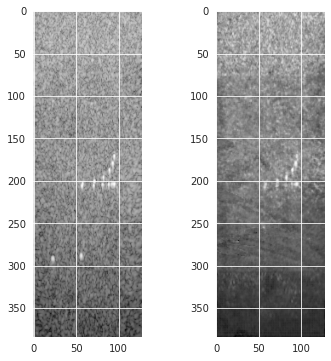

In [ ]:
network_eval()